# Business Context and Problem Statement
A growing hotel chain operates multiple bars across various locations. These bars frequently experience:
- **Stockouts** of high-demand items, leading to lost revenue and reduced guest satisfaction.
- **Overstocking** of slow-moving inventory, increasing holding costs and waste.

**Goal:** Build a forecasting and inventory recommendation system to help bar managers optimize inventory levels per item and location.

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style='darkgrid', palette='rainbow')
%matplotlib inline

In [2]:
# Importing Data

df= pd.read_csv('Consumption Dataset - Dataset.csv')
df

,Date Time Served,Bar Name,Alcohol Type,Brand Name,Opening Balance (ml),Purchase (ml),Consumed (ml),Closing Balance (ml)
0,1/1/2023 19:35,Smith's Bar,Rum,Captain Morgan,2.555040e+03,1824.84,0.00,4379.88
1,1/1/2023 10:07,Smith's Bar,Wine,Yellow Tail,1.344370e+03,0.00,0.00,1344.37
2,1/1/2023 11:26,Johnson's Bar,Vodka,Grey Goose,1.034280e+03,0.00,0.00,1034.28
3,1/1/2023 13:53,Johnson's Bar,Beer,Coors,2.194530e+03,0.00,0.00,2194.53
4,1/1/2023 22:28,Johnson's Bar,Wine,Yellow Tail,1.020900e+03,0.00,0.00,1020.90
...,...,...,...,...,...,...,...,...
6570,1/1/2024 21:03,Anderson's Bar,Beer,Coors,2.467080e+03,0.00,321.06,2146.02
6571,1/1/2024 21:15,Anderson's Bar,Rum,Malibu,8.530000e-14,1743.64,175.05,1568.59
6572,1/1/2024 18:34,Anderson's Bar,Whiskey,Jack Daniels,4.192660e+03,0.00,197.60,3995.06
6573,1/1/2024 22:46,Thomas's Bar,Vodka,Absolut,2.424950e+03,0.00,128.52,2296.43


# Data preprocessing

In [3]:
df.describe()

,Opening Balance (ml),Purchase (ml),Consumed (ml),Closing Balance (ml)
count,6575.000000,6575.000000,6575.000000,6575.000000
mean,2468.397180,315.841757,299.419264,2484.811748
std,2284.552895,582.120264,191.903874,2302.363298
min,0.000000,0.000000,0.000000,0.000000
25%,619.135000,0.000000,156.640000,611.000000
50%,1848.440000,0.000000,300.390000,1849.840000
75%,3853.020000,526.345000,450.870000,3906.050000
max,11862.520000,1999.840000,1180.580000,11862.520000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6575 entries, 0 to 6574
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date Time Served      6575 non-null   object 
 1   Bar Name              6575 non-null   object 
 2   Alcohol Type          6575 non-null   object 
 3   Brand Name            6575 non-null   object 
 4   Opening Balance (ml)  6575 non-null   float64
 5   Purchase (ml)         6575 non-null   float64
 6   Consumed (ml)         6575 non-null   float64
 7   Closing Balance (ml)  6575 non-null   float64
dtypes: float64(4), object(4)
memory usage: 411.1+ KB


In [5]:
df.shape

(6575, 8)

In [6]:
df.isnull().sum()

Date Time Served        0
Bar Name                0
Alcohol Type            0
Brand Name              0
Opening Balance (ml)    0
Purchase (ml)           0
Consumed (ml)           0
Closing Balance (ml)    0
dtype: int64

In [7]:
df.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
6570    False
6571    False
6572    False
6573    False
6574    False
Length: 6575, dtype: bool

### Identifies possible values in key categorical features.

In [8]:
df['Bar Name'].unique()

array(["Smith's Bar", "Johnson's Bar", "Brown's Bar", "Taylor's Bar",
       "Anderson's Bar", "Thomas's Bar"], dtype=object)

In [9]:
df['Alcohol Type'].unique()

array(['Rum', 'Wine', 'Vodka', 'Beer', 'Whiskey'], dtype=object)

In [10]:
df['Brand Name'].unique()

array(['Captain Morgan', 'Yellow Tail', 'Grey Goose', 'Coors', 'Jim Beam',
       'Absolut', 'Jack Daniels', 'Sutter Home', 'Miller', 'Bacardi',
       'Malibu', 'Jameson', 'Smirnoff', 'Budweiser', 'Heineken',
       'Barefoot'], dtype=object)

### Shows frequency distribution of categories.

In [11]:
df['Bar Name'].value_counts()

Bar Name
Johnson's Bar     1106
Anderson's Bar    1102
Thomas's Bar      1101
Brown's Bar       1100
Taylor's Bar      1088
Smith's Bar       1078
Name: count, dtype: int64

In [12]:
df['Alcohol Type'].value_counts()

Alcohol Type
Vodka      1331
Wine       1316
Whiskey    1316
Rum        1310
Beer       1302
Name: count, dtype: int64

In [13]:
df['Brand Name'].value_counts()

Brand Name
Yellow Tail       479
Captain Morgan    471
Grey Goose        465
Jim Beam          455
Smirnoff          434
Jack Daniels      433
Absolut           432
Jameson           428
Malibu            425
Barefoot          424
Bacardi           414
Sutter Home       413
Miller            363
Coors             325
Heineken          314
Budweiser         300
Name: count, dtype: int64

In [14]:
#We only need the date part (not time) to group daily sales.
df['Date'] = pd.to_datetime(df['Date Time Served']).dt.date

In [15]:
# Group by Date, Bar, and Brand
daily_consumption = df.groupby(['Date', 'Bar Name', 'Brand Name'], as_index=False).agg({
    'Consumed (ml)': 'sum'
})

# Rename the column for clarity
daily_consumption = daily_consumption.rename(columns={'Consumed (ml)': 'Total Consumed (ml)'})

In [16]:
daily_consumption

,Date,Bar Name,Brand Name,Total Consumed (ml)
0,2023-01-01,Anderson's Bar,Bacardi,0.00
1,2023-01-01,Anderson's Bar,Jim Beam,0.00
2,2023-01-01,Anderson's Bar,Miller,0.00
3,2023-01-01,Anderson's Bar,Sutter Home,0.00
4,2023-01-01,Brown's Bar,Captain Morgan,0.00
...,...,...,...,...
6570,2024-01-01,Taylor's Bar,Budweiser,558.72
6571,2024-01-01,Taylor's Bar,Captain Morgan,440.76
6572,2024-01-01,Taylor's Bar,Jim Beam,253.33
6573,2024-01-01,Thomas's Bar,Absolut,128.52


In [17]:
# Get all unique dates from the dataset
all_dates = pd.date_range(start=daily_consumption['Date'].min(), end=daily_consumption['Date'].max())

In [18]:
all_dates

DatetimeIndex(['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04',
               '2023-01-05', '2023-01-06', '2023-01-07', '2023-01-08',
               '2023-01-09', '2023-01-10',
               ...
               '2023-12-23', '2023-12-24', '2023-12-25', '2023-12-26',
               '2023-12-27', '2023-12-28', '2023-12-29', '2023-12-30',
               '2023-12-31', '2024-01-01'],
              dtype='datetime64[ns]', length=366, freq='D')

In [19]:
# Get all unique Bar Name and Brand Name combinations
bar_brand_combinations = daily_consumption[['Bar Name', 'Brand Name']].drop_duplicates()

In [20]:
bar_brand_combinations

,Bar Name,Brand Name
0,Anderson's Bar,Bacardi
1,Anderson's Bar,Jim Beam
2,Anderson's Bar,Miller
3,Anderson's Bar,Sutter Home
4,Brown's Bar,Captain Morgan
...,...,...
207,Taylor's Bar,Budweiser
234,Thomas's Bar,Jack Daniels
236,Anderson's Bar,Captain Morgan
243,Johnson's Bar,Budweiser


In [21]:
# Create a complete DataFrame with all combinations of Date, Bar Name, and Brand Name
complete_index = pd.MultiIndex.from_product(
    [all_dates, bar_brand_combinations['Bar Name'], bar_brand_combinations['Brand Name']],
    names=['Date', 'Bar Name', 'Brand Name']
)

In [22]:
complete_index

MultiIndex([('2023-01-01', 'Anderson's Bar',        'Bacardi'),
            ('2023-01-01', 'Anderson's Bar',       'Jim Beam'),
            ('2023-01-01', 'Anderson's Bar',         'Miller'),
            ('2023-01-01', 'Anderson's Bar',    'Sutter Home'),
            ('2023-01-01', 'Anderson's Bar', 'Captain Morgan'),
            ('2023-01-01', 'Anderson's Bar',     'Grey Goose'),
            ('2023-01-01', 'Anderson's Bar',       'Jim Beam'),
            ('2023-01-01', 'Anderson's Bar',          'Coors'),
            ('2023-01-01', 'Anderson's Bar',     'Grey Goose'),
            ('2023-01-01', 'Anderson's Bar',    'Yellow Tail'),
            ...
            ('2024-01-01',    'Smith's Bar',        'Bacardi'),
            ('2024-01-01',    'Smith's Bar',       'Jim Beam'),
            ('2024-01-01',    'Smith's Bar',          'Coors'),
            ('2024-01-01',    'Smith's Bar',        'Bacardi'),
            ('2024-01-01',    'Smith's Bar',       'Smirnoff'),
            ('2024-01-01

## we have a row — even if no consumption occurred on that day (which is shown as 0.0).

## This is crucial for time series forecasting because models need a continuous sequence of dates to learn patterns like trends and seasonality.

In [23]:
# Reindex the existing data to include all date-bar-brand combinations
complete_df = (
    daily_consumption.set_index(['Date', 'Bar Name', 'Brand Name'])
    .reindex(complete_index, fill_value=0)
    .reset_index()
)

In [24]:
# Show a sample of the filled-in data
complete_df

,Date,Bar Name,Brand Name,Total Consumed (ml)
0,2023-01-01,Anderson's Bar,Bacardi,0.00
1,2023-01-01,Anderson's Bar,Jim Beam,0.00
2,2023-01-01,Anderson's Bar,Miller,0.00
3,2023-01-01,Anderson's Bar,Sutter Home,0.00
4,2023-01-01,Anderson's Bar,Captain Morgan,0.00
...,...,...,...,...
3373051,2024-01-01,Smith's Bar,Budweiser,0.00
3373052,2024-01-01,Smith's Bar,Jack Daniels,0.00
3373053,2024-01-01,Smith's Bar,Captain Morgan,508.91
3373054,2024-01-01,Smith's Bar,Budweiser,0.00


# Data Preparation
We parse the date field, clean the data, and calculate daily consumption totals per bar and item to enable time series forecasting.

In [25]:
# Convert date and aggregate daily consumption
df['Date Time Served'] = pd.to_datetime(df['Date Time Served'])
df['Date'] = df['Date Time Served'].dt.date

In [26]:
# Group by bar, brand, and date to calculate daily consumption
daily_consumption = df.groupby(['Bar Name', 'Brand Name', 'Date'])['Consumed (ml)'].sum().reset_index()
daily_consumption = daily_consumption.sort_values(['Bar Name', 'Brand Name', 'Date'])
daily_consumption.head()

,Bar Name,Brand Name,Date,Consumed (ml)
0,Anderson's Bar,Absolut,2023-01-02,118.62
1,Anderson's Bar,Absolut,2023-01-05,463.20
2,Anderson's Bar,Absolut,2023-01-06,453.02
3,Anderson's Bar,Absolut,2023-01-08,275.08
4,Anderson's Bar,Absolut,2023-01-11,0.00


# Data Visualization

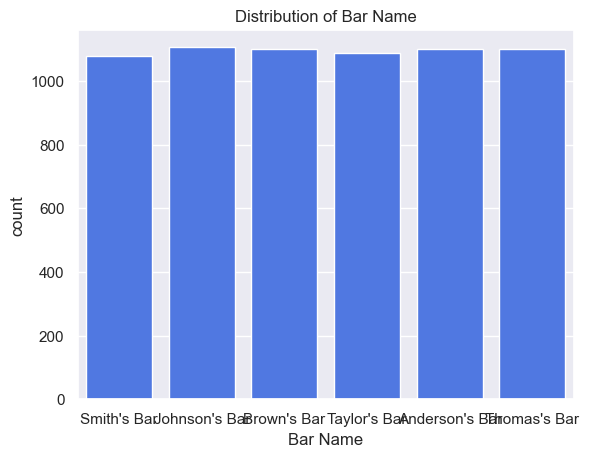

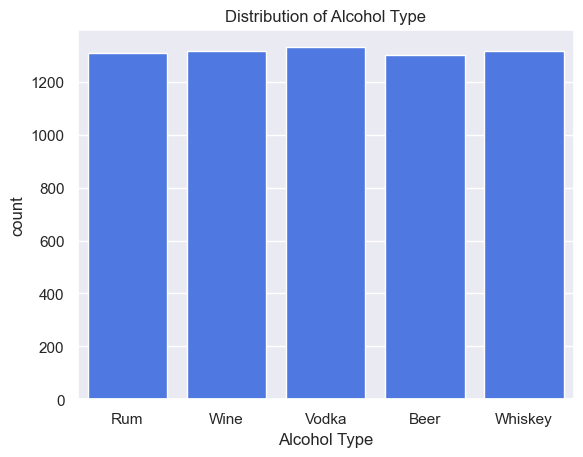

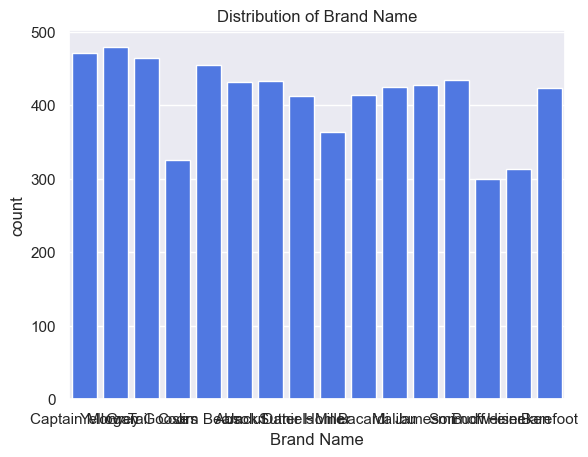

In [27]:
# Uses count plots to visualize distribution of categories.
categorical_cols = ['Bar Name', 'Alcohol Type', 'Brand Name']
for col in categorical_cols:
    sns.countplot(data=df, x=col)
    plt.title(f'Distribution of {col}')
    plt.show()

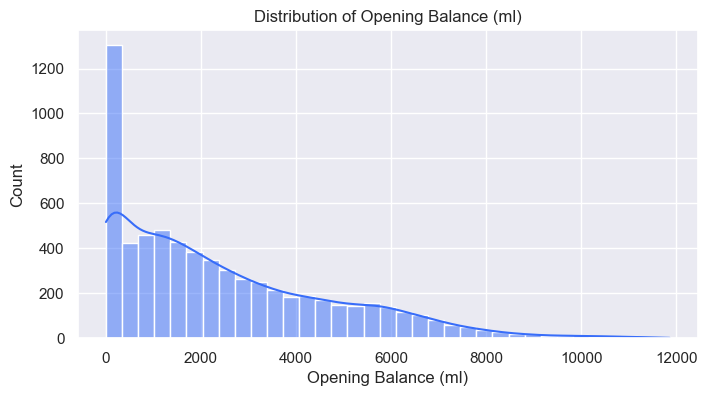

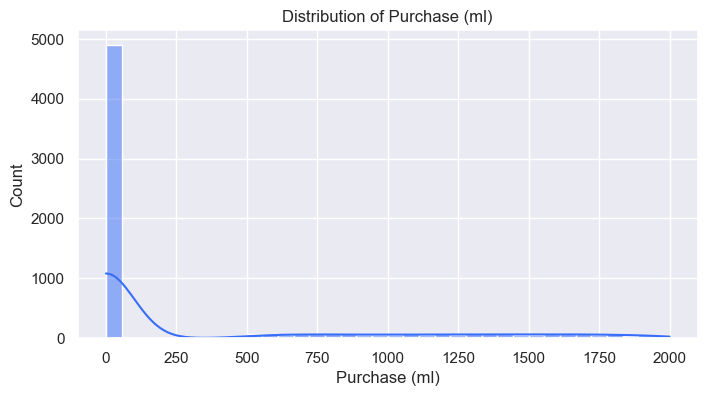

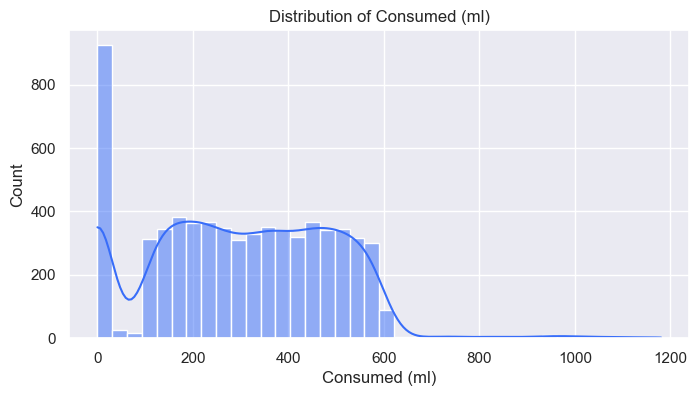

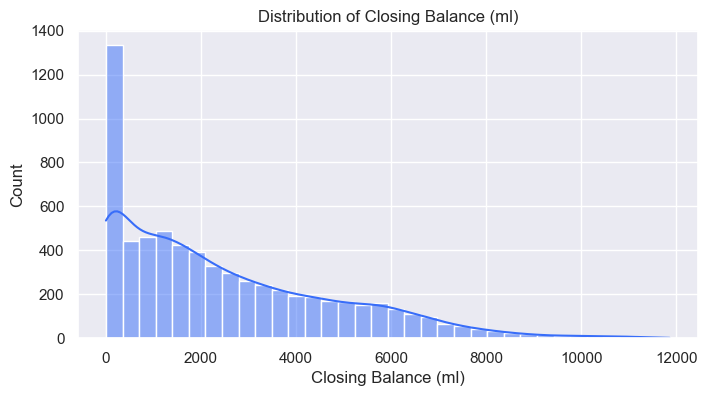

In [28]:
#Plots histogram with KDE (smooth curve) for each numerical column.
numerical_cols = ['Opening Balance (ml)','Purchase (ml)','Consumed (ml)','Closing Balance (ml)']

for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

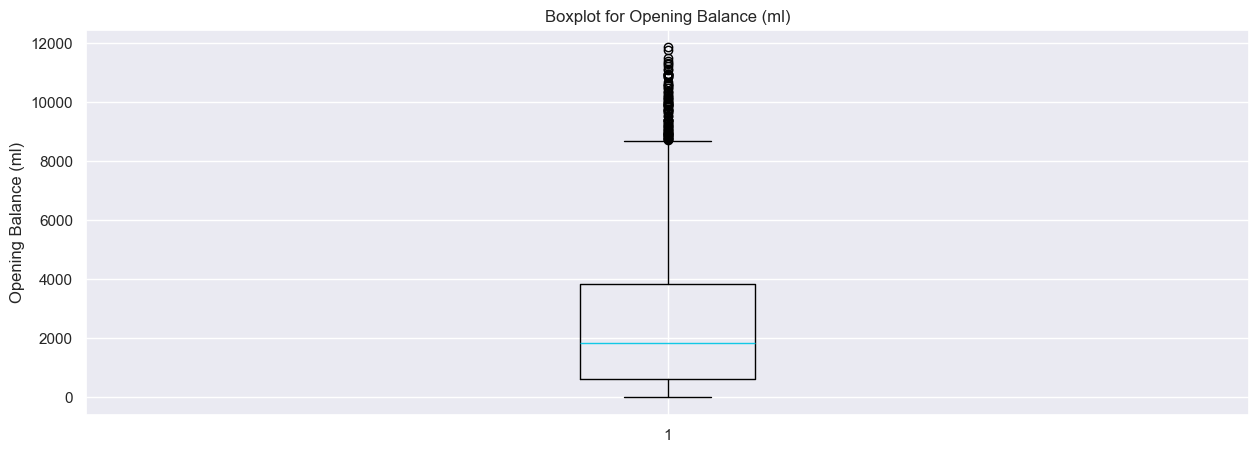

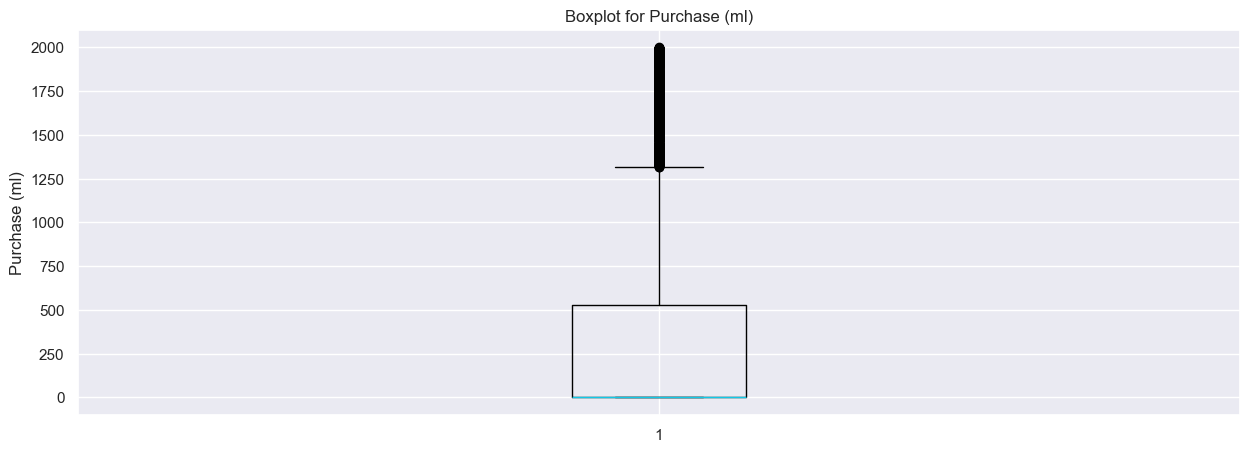

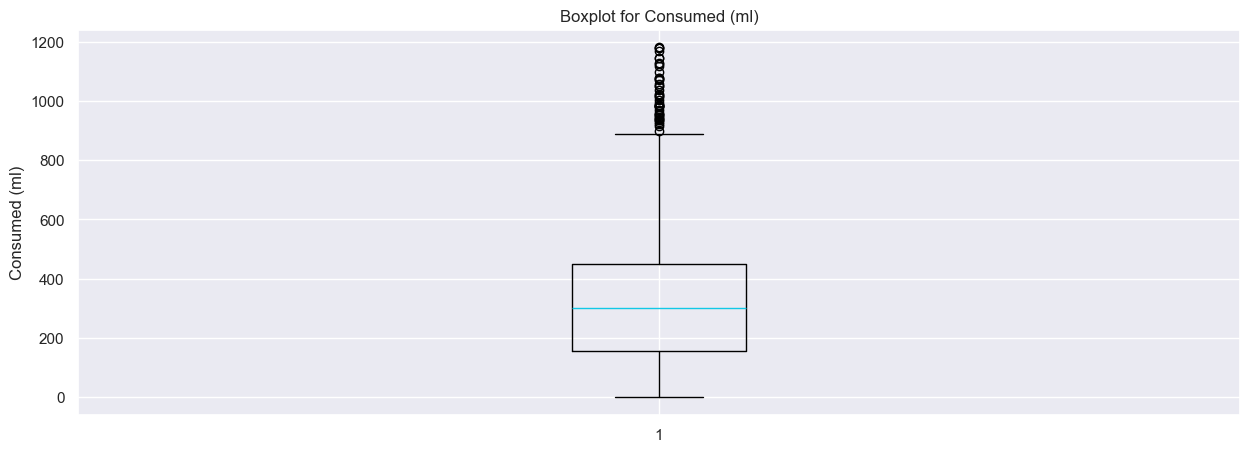

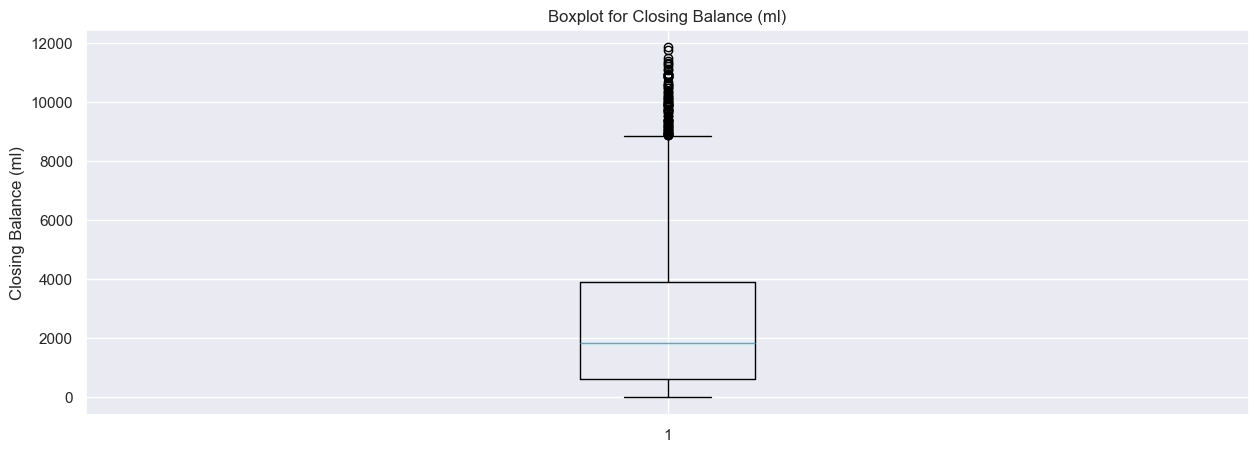

In [29]:
# checking Outlines
for col in numerical_cols:
    plt.figure(figsize=(15,5))  # Create a new figure for each plot
    plt.boxplot(df[col])
    plt.title(f"Boxplot for {col}")
    plt.ylabel(col)
    plt.show()

In [30]:
#outlier Detection
def outlier_Detection(df,columns):
    for col in columns:
        Q1=df[col].quantile(0.25)
        Q3=df[col].quantile(0.75)
        iqr=Q3-Q1
        lower=Q1-1.5*iqr
        upper=Q3+1.5*iqr
        df[col]=np.where(df[col]>upper,upper,np.where(df[col]<lower,lower,df[col]))
    return df        

In [31]:
outlier_Detection(df,['Opening Balance (ml)','Purchase (ml)','Consumed (ml)','Closing Balance (ml)'])

,Date Time Served,Bar Name,Alcohol Type,Brand Name,Opening Balance (ml),Purchase (ml),Consumed (ml),Closing Balance (ml),Date
0,2023-01-01 19:35:00,Smith's Bar,Rum,Captain Morgan,2.555040e+03,1315.8625,0.00,4379.88,2023-01-01
1,2023-01-01 10:07:00,Smith's Bar,Wine,Yellow Tail,1.344370e+03,0.0000,0.00,1344.37,2023-01-01
2,2023-01-01 11:26:00,Johnson's Bar,Vodka,Grey Goose,1.034280e+03,0.0000,0.00,1034.28,2023-01-01
3,2023-01-01 13:53:00,Johnson's Bar,Beer,Coors,2.194530e+03,0.0000,0.00,2194.53,2023-01-01
4,2023-01-01 22:28:00,Johnson's Bar,Wine,Yellow Tail,1.020900e+03,0.0000,0.00,1020.90,2023-01-01
...,...,...,...,...,...,...,...,...,...
6570,2024-01-01 21:03:00,Anderson's Bar,Beer,Coors,2.467080e+03,0.0000,321.06,2146.02,2024-01-01
6571,2024-01-01 21:15:00,Anderson's Bar,Rum,Malibu,8.530000e-14,1315.8625,175.05,1568.59,2024-01-01
6572,2024-01-01 18:34:00,Anderson's Bar,Whiskey,Jack Daniels,4.192660e+03,0.0000,197.60,3995.06,2024-01-01
6573,2024-01-01 22:46:00,Thomas's Bar,Vodka,Absolut,2.424950e+03,0.0000,128.52,2296.43,2024-01-01


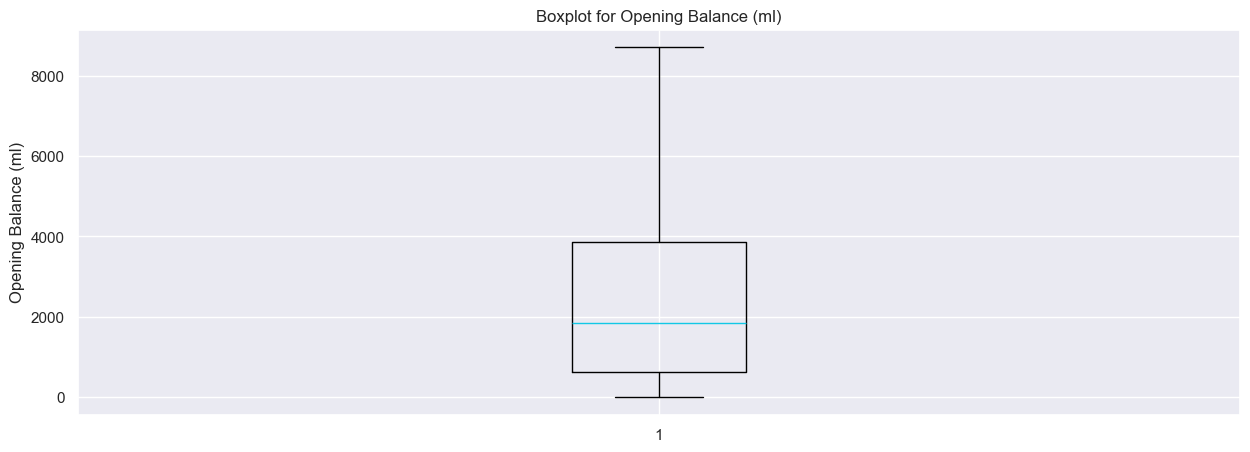

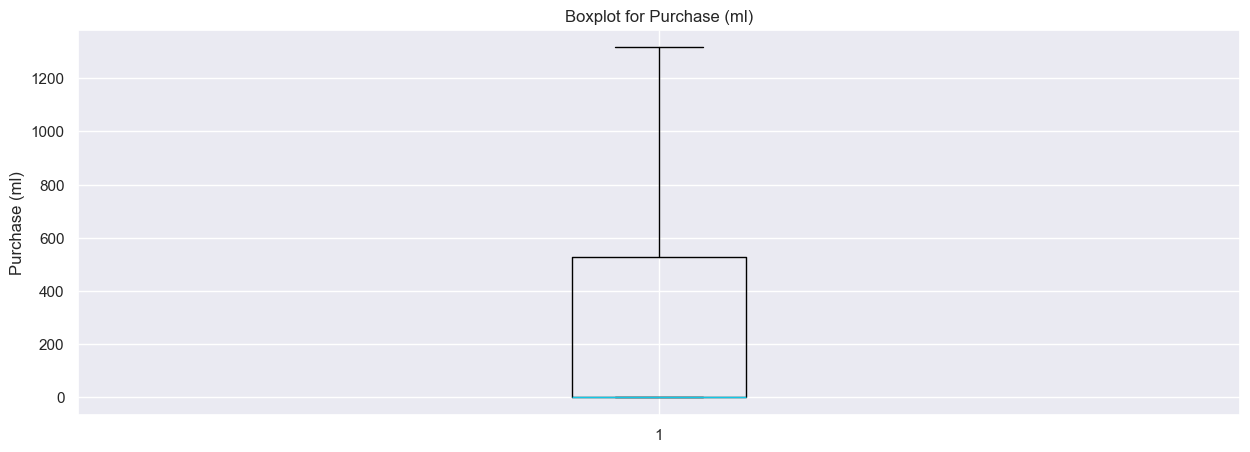

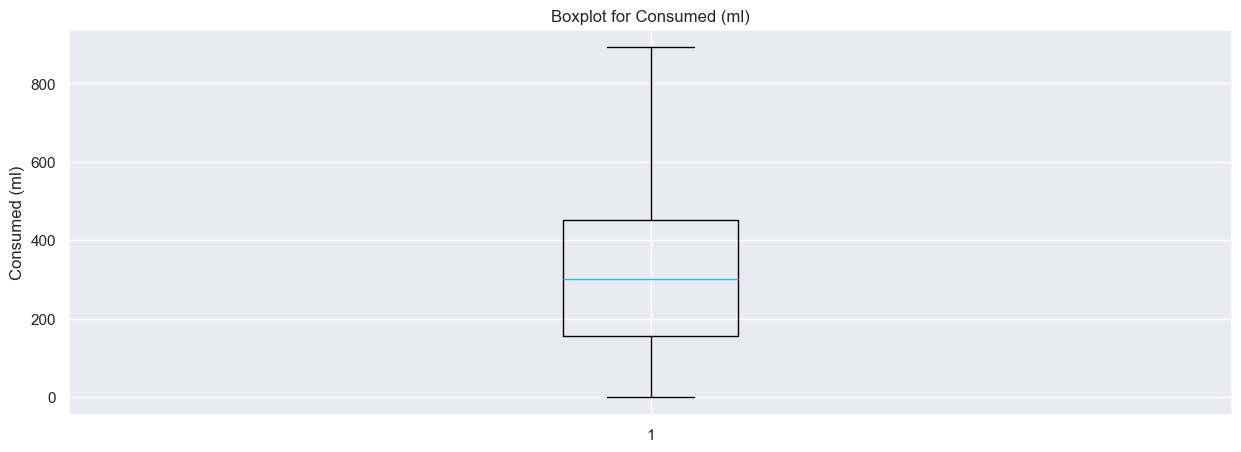

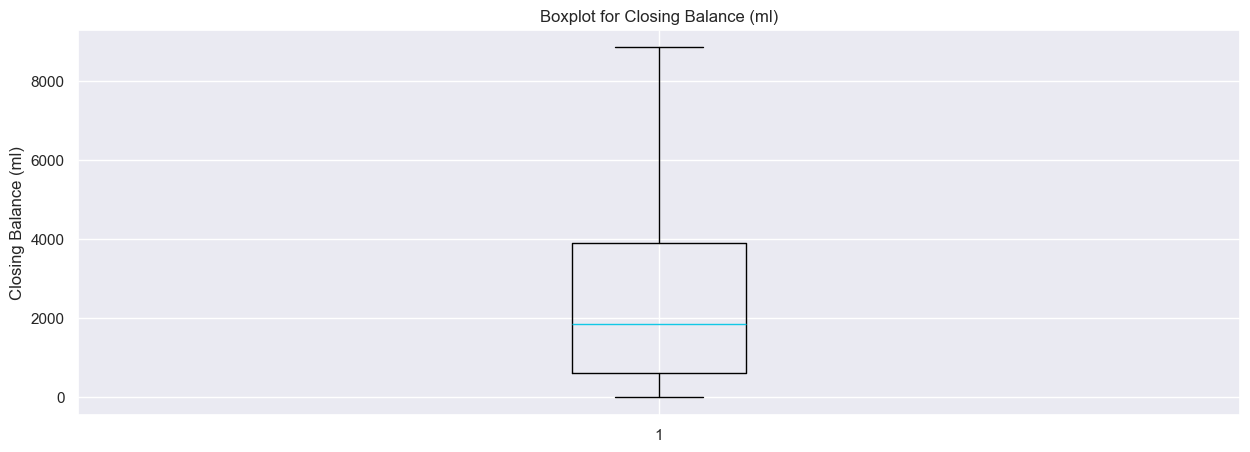

In [32]:
# After Outlier Detection
for column in numerical_cols:
    plt.figure(figsize=(15,5))  # Create a new figure for each plot
    plt.boxplot(df[column])
    plt.title(f"Boxplot for {column}")
    plt.ylabel(column)
    plt.show()

In [33]:
# Filter for one item: e.g., Absolut at Anderson's Bar
sample_item = complete_df[
    (complete_df['Bar Name'] == "Anderson's Bar") &
    (complete_df['Brand Name'] == "Absolut")
]

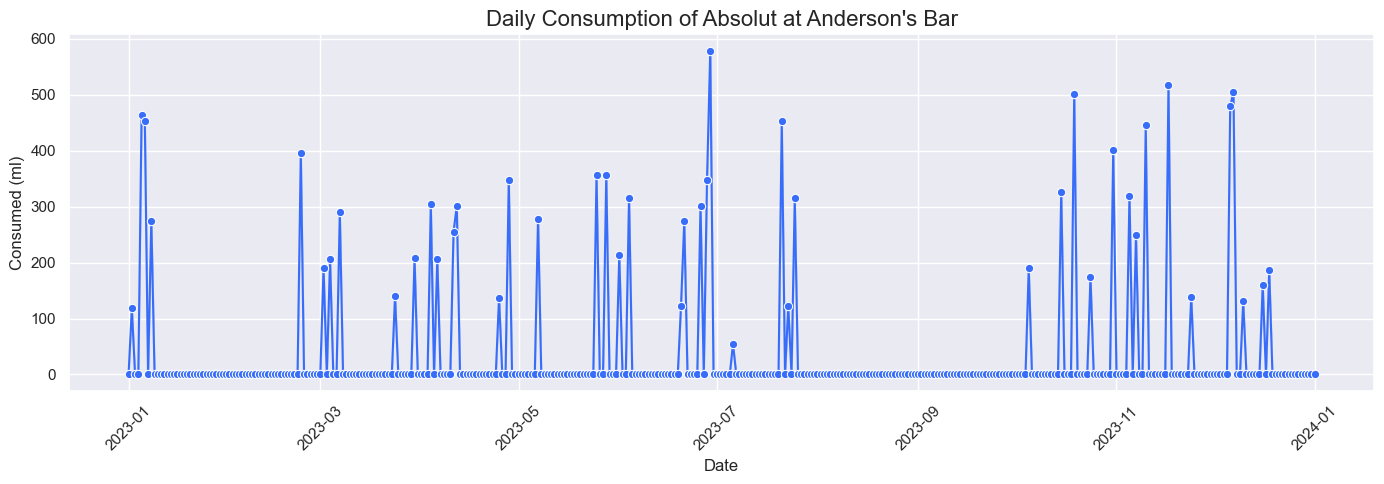

In [34]:
# Plot
plt.figure(figsize=(14, 5))
sns.lineplot(data=sample_item, x='Date', y='Total Consumed (ml)', marker='o')
plt.title("Daily Consumption of Absolut at Anderson's Bar", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Consumed (ml)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

In [35]:
# Filter for one item: e.g., Captain Morgan at Smith's Bar
sample_item01 = complete_df[
    (complete_df['Bar Name'] == "Smith's Bar") &
    (complete_df['Brand Name'] == "Captain Morgan")
]

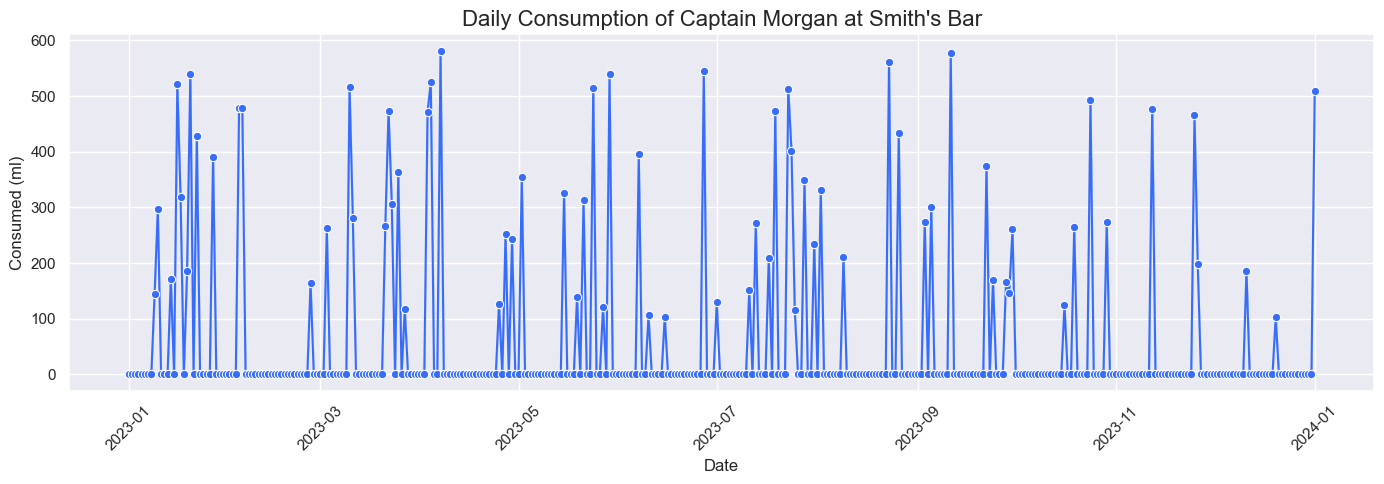

In [36]:
# Plot
plt.figure(figsize=(14, 5))
sns.lineplot(data=sample_item01, x='Date', y='Total Consumed (ml)', marker='o')
plt.title("Daily Consumption of Captain Morgan at Smith's Bar", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Consumed (ml)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

In [37]:
# Filter for one item: e.g.,Budweiser at Taylor's Bar
sample_item02 = complete_df[
    (complete_df['Bar Name'] == "Taylor's Bar") &
    (complete_df['Brand Name'] == "Budweiser")
]

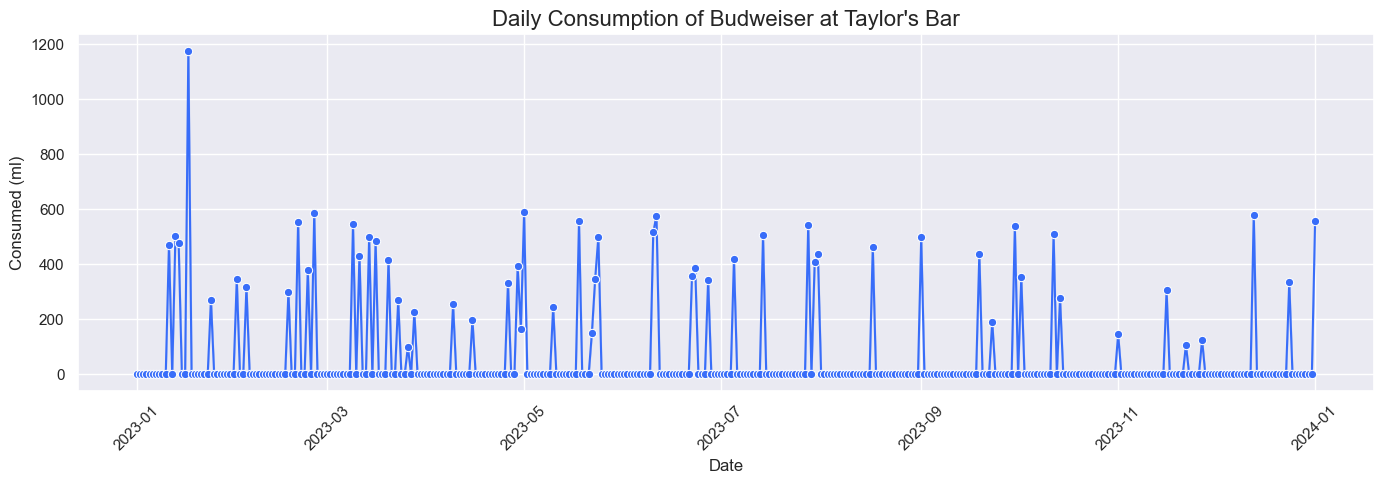

In [38]:
# Plot
plt.figure(figsize=(14, 5))
sns.lineplot(data=sample_item02, x='Date', y='Total Consumed (ml)', marker='o')
plt.title("Daily Consumption of Budweiser at Taylor's Bar", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Consumed (ml)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

# forecasting and par level recommendation

In [39]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error,mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [40]:
results = []

# Loop over each unique Bar + Brand combination
for (bar, brand), group in daily_consumption.groupby(['Bar Name', 'Brand Name']):
    ts = group.set_index('Date')['Consumed (ml)'].asfreq('D').fillna(0)
    
    if len(ts) < 20:
        continue  # Skip short series
    
    train = ts[:-7]
    test = ts[-7:]
    def calculate_rmse(test, forecast):
        return np.sqrt(mean_squared_error(test, forecast))
    
    try:
        model = ARIMA(train, order=(2,1,2))
        fitted_model = model.fit()
        forecast = fitted_model.forecast(steps=7)
        
        forecast_7day = forecast.sum()
        mae = mean_absolute_error(test, forecast)
        mape = mean_absolute_percentage_error(test, forecast)
        rmse = calculate_rmse(test, forecast)
        results.append({
            'Bar Name': bar,
            'Brand Name': brand,
            'Forecast (7-day sum)': forecast_7day,
            'MAE': mae,
            'MAPE': mape,
            'RMSE': rmse
        })
    except Exception as e:
        print(f"ARIMA failed for {bar} - {brand}: {e}")
        continue

In [41]:
# Convert to DataFrame
arima_forecast_df = pd.DataFrame(results)
arima_forecast_df.sort_values('Forecast (7-day sum)', ascending=False).head()

,Bar Name,Brand Name,Forecast (7-day sum),MAE,MAPE,RMSE
61,Smith's Bar,Smirnoff,666.897908,148.620149,2.467551e+17,185.974799
77,Taylor's Bar,Smirnoff,664.793502,184.495333,2.399521e+17,226.229317
62,Smith's Bar,Sutter Home,592.894607,114.983877,2.776636e+17,124.009667
70,Taylor's Bar,Grey Goose,586.674031,112.342412,2.726096e+17,133.509886
31,Brown's Bar,Yellow Tail,573.019502,122.474056,3.179888e+17,157.020713


# Forecasting Item-Level Demand
We apply time series forecasting (Exponential Smoothing) for each (Bar, Brand) combination to predict the next week's demand.

In [42]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [43]:
# Forecast next 7 days demand per Bar and Brand
forecast_results = []
future_days = 7
for (bar, brand), group in daily_consumption.groupby(['Bar Name', 'Brand Name']):
    ts = group.set_index('Date')['Consumed (ml)'].asfreq('D').fillna(0)
    if len(ts) > 30:
        model = ExponentialSmoothing(ts, trend='add', seasonal=None)
        fit = model.fit()
        forecast = fit.forecast(future_days)
        forecast_results.append({
            'Bar Name': bar,
            'Brand Name': brand,
            'Forecast (7-day sum)': forecast.sum()
        })

In [44]:
forecast_df = pd.DataFrame(forecast_results)
forecast_df.head()

,Bar Name,Brand Name,Forecast (7-day sum)
0,Anderson's Bar,Absolut,157.677193
1,Anderson's Bar,Bacardi,1086.308101
2,Anderson's Bar,Barefoot,332.605092
3,Anderson's Bar,Budweiser,-39.865506
4,Anderson's Bar,Captain Morgan,1435.672406


# Inventory Par Level Recommendation
We recommend par levels as:
`Par Level = Forecast + Safety Stock`
Where safety stock is set to 20% of the forecast to account for demand variability.

In [45]:
# Add safety stock
forecast_df['Safety Stock'] = forecast_df['Forecast (7-day sum)'] * 0.2
forecast_df['Recommended Par Level'] = forecast_df['Forecast (7-day sum)'] + forecast_df['Safety Stock']
forecast_df.head()

,Bar Name,Brand Name,Forecast (7-day sum),Safety Stock,Recommended Par Level
0,Anderson's Bar,Absolut,157.677193,31.535439,189.212632
1,Anderson's Bar,Bacardi,1086.308101,217.261620,1303.569721
2,Anderson's Bar,Barefoot,332.605092,66.521018,399.126110
3,Anderson's Bar,Budweiser,-39.865506,-7.973101,-47.838607
4,Anderson's Bar,Captain Morgan,1435.672406,287.134481,1722.806887


# Inventory System Simulation
We simulate inventory over a week using forecasted demand and compare outcomes with vs. without using the par level.

In [46]:
# Simulate for one bar and brand
example = forecast_df.iloc[0]
bar, brand = example['Bar Name'], example['Brand Name']

history = daily_consumption[(daily_consumption['Bar Name'] == bar) & (daily_consumption['Brand Name'] == brand)]
ts = history.set_index('Date')['Consumed (ml)'].asfreq('D').fillna(0)
last_stock = 2000  # Assume starting inventory
sim = pd.DataFrame({'Actual Demand': ts[-7:]})
sim['Inventory (w/o Par)'] = last_stock - sim['Actual Demand'].cumsum()
sim['Inventory (w/ Par)'] = example['Recommended Par Level'] - sim['Actual Demand'].cumsum()
sim

,Actual Demand,Inventory (w/o Par),Inventory (w/ Par)
Date,,,
2023-12-19,0.0,2000.0,189.212632
2023-12-20,0.0,2000.0,189.212632
2023-12-21,0.0,2000.0,189.212632
2023-12-22,0.0,2000.0,189.212632
2023-12-23,0.0,2000.0,189.212632
2023-12-24,0.0,2000.0,189.212632
2023-12-25,0.0,2000.0,189.212632


 # Multi-location Simulation

In [47]:
# Multi-location simulation: simulate inventory for top 3 high-demand (Bar, Brand) combinations
top_items = forecast_df.sort_values('Forecast (7-day sum)', ascending=False).head(3)
simulation_results = []

for _, row in top_items.iterrows():
    bar, brand = row['Bar Name'], row['Brand Name']
    par = row['Recommended Par Level']
    history = daily_consumption[(daily_consumption['Bar Name'] == bar) & (daily_consumption['Brand Name'] == brand)]
    ts = history.set_index('Date')['Consumed (ml)'].asfreq('D').fillna(0)
    sim = pd.DataFrame({'Actual Demand': ts[-7:]})
    sim['Inventory (w/o Par)'] = 2000 - sim['Actual Demand'].cumsum()
    sim['Inventory (w/ Par)'] = par - sim['Actual Demand'].cumsum()
    sim['Bar'] = bar
    sim['Brand'] = brand
    simulation_results.append(sim.reset_index())

multi_sim_df = pd.concat(simulation_results, ignore_index=True)
multi_sim_df.head()


,Date,Actual Demand,Inventory (w/o Par),Inventory (w/ Par),Bar,Brand
0,2023-12-21,0.00,2000.00,2180.075919,Thomas's Bar,Grey Goose
1,2023-12-22,0.00,2000.00,2180.075919,Thomas's Bar,Grey Goose
2,2023-12-23,395.97,1604.03,1784.105919,Thomas's Bar,Grey Goose
3,2023-12-24,0.00,1604.03,1784.105919,Thomas's Bar,Grey Goose
4,2023-12-25,0.00,1604.03,1784.105919,Thomas's Bar,Grey Goose


# Forecast Visualization

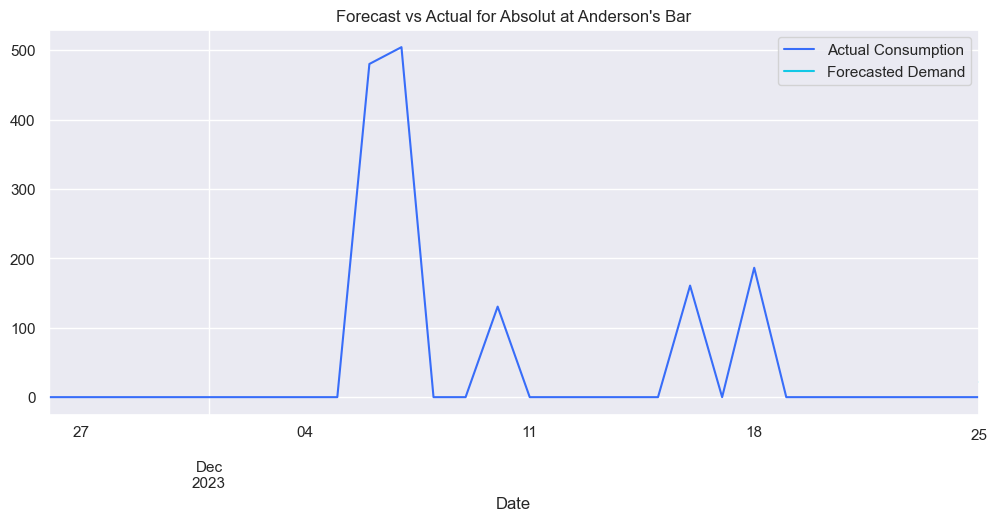

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

example = forecast_df.iloc[0]
bar, brand = example['Bar Name'], example['Brand Name']
history = daily_consumption[(daily_consumption['Bar Name'] == bar) & (daily_consumption['Brand Name'] == brand)]
ts = history.set_index('Date')['Consumed (ml)'].asfreq('D').fillna(0)

plt.figure(figsize=(12, 5))
ts[-30:].plot(label='Actual Consumption')
forecast_line = [example['Forecast (7-day sum)']/7] * 7
plt.plot(pd.date_range(ts.index[-1], periods=7, freq='D'), forecast_line, label='Forecasted Demand')
plt.title(f"Forecast vs Actual for {brand} at {bar}")
plt.legend()
plt.grid(True)
plt.show()


# Comparision of all model performance

# ARIMA Model VS Exponential Smoothing VS Holtwinters

In [49]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [50]:
# Choose one time series: Bar + Brand
bar, brand = forecast_df.iloc[0]['Bar Name'], forecast_df.iloc[0]['Brand Name']
history = daily_consumption[(daily_consumption['Bar Name'] == bar) & (daily_consumption['Brand Name'] == brand)]
ts = history.groupby('Date')['Consumed (ml)'].sum().asfreq('D').fillna(0)

In [51]:
# Train/test split
train = ts[:-7]
test = ts[-7:]

In [52]:
# Simple Exponential Smoothing 
ses_model = SimpleExpSmoothing(train).fit()
ses_pred = ses_model.forecast(7)

In [53]:
# Holt’s Linear Trend 
holt_model = Holt(train).fit()
holt_pred = holt_model.forecast(7)

In [54]:
#  Exponential Smoothing (Holt-Winters, no seasonality) 
hw_model = ExponentialSmoothing(train, trend='add', seasonal=None).fit()
hw_pred = hw_model.forecast(7)

In [61]:
#  Evaluation Metrics 
def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = calculate_rmse(test, forecast)
    print(f"{name:30s} MAE: {mae:.2f}, MAPE: {mape:.2%},RMSE: {rmse:.2%}")

In [62]:
evaluate_model("ARIMA Model", test, forecast)
evaluate_model("Simple Exp Smoothing", test, ses_pred)
evaluate_model("Holt Linear Trend", test, holt_pred)
evaluate_model("Holt-Winters (Additive)", test, hw_pred)


ARIMA Model                    MAE: 167.40, MAPE: 75391005651613761536.00%,RMSE: 16799.77%
Simple Exp Smoothing           MAE: 68.20, MAPE: 30713383225240223744.00%,RMSE: 16799.77%
Holt Linear Trend              MAE: 79.54, MAPE: 35822849214897336320.00%,RMSE: 16799.77%
Holt-Winters (Additive)        MAE: 73.80, MAPE: 33234986737403072512.00%,RMSE: 16799.77%
